In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
sns.set_theme(context='notebook')


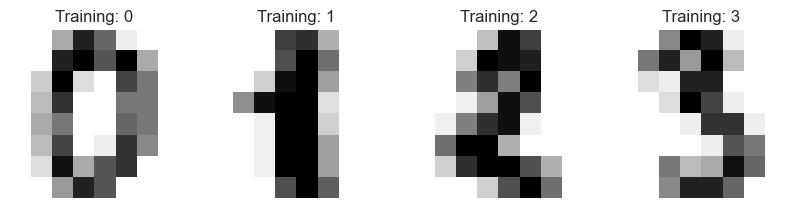

In [2]:
# Load the digits dataset from scikit-learn
digits = datasets.load_digits()

# Create a figure with 1 row and 4 columns of subplots, and set the size of the figure
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))

# Iterate through the subplots and the images and labels from the digits dataset
# and plot each image in a subplot, with the corresponding label as the title
for ax, image, label in zip(axes, digits.images, digits.target):
    # Turn off the axis lines and labels for each subplot
    ax.set_axis_off()
    # Display the image in the subplot, using a grayscale color map
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    # Set the title of the subplot to the corresponding label
    ax.set_title("Training: %i" % label)


In [3]:
def oneHot(x, classes):
    # Convert a 1D array of integers to a 2D one-hot encoded array
    return np.eye(classes)[x]

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize the values in a numpy array so that they lie between 0 and 1
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Get the number of samples in the digits dataset
n_samples = len(digits.images)

# Reshape the images array to a 2D array of shape (n_samples, 64)
data = digits.images.reshape((n_samples, -1))

# Get the labels for each image
labels = digits.target

# Split the data and labels into training and test sets
split = int(0.8 * len(labels))
x_train = data[:split].T
y_train = labels[:split]

# Convert the training labels to one-hot encoding
y_train = oneHot(y_train, 10).T

# Get the test data and labels
x_test = data[split:].T
y_test = labels[split:]

# Save a copy of the test labels before they are one-hot encoded
y_testDash = y_test

# Convert the test labels to one-hot encoding
y_test = oneHot(y_test, 10).T

# Normalize the training data
x_train = normalize(x_train)

# Print the shapes of the training and test data and labels
print('Shapes: x_train: {}, y_train: {}, x_test: {}, y_test: {}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))


Shapes: x_train: (64, 1437), y_train: (10, 1437), x_test: (64, 360), y_test: (10, 360)


In [4]:
class NeuralNetwork(object):
    def __init__(self, x_train, y_train, activation, network):
        # Initialize the class with the training data, labels, and network architecture
        self.epsilon = 1e-7
        self.x_train = x_train
        self.y_train = y_train
        self.network = network
        self.activation = activation 
        self.paramsDict = {}
        self.layers = {}
        self.m = x_train.shape[1]  # Number of training examples
        self.networkLen = len(network)  # Number of layers in the network

    def getAccuracy(self, X, y):
        # Calculate the accuracy of the model on the given data and labels
        P = self.predict(X)
        return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100

    def softmax(self, z):
        # Calculate the softmax activation function
        e = np.exp(z - np.max(z))
        return e / np.sum(e, axis=0, keepdims=True)

    def activationFunction(self, z):
        # Calculate the activation function for a given input
        if self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "relu":
            return (z > 0) * 1

    def activationDerivative(self, z):
        # Calculate the derivative of the activation function for a given input
        if self.activation == "tanh":
            return 1 - np.square(self.activationFunction(z))
        if self.activation == "relu":
            y = (z > 0) * 1
            return y

        
    def init_params(self):
        for i in range(1, self.networkLen):
            self.paramsDict["W"+str(i)] = np.random.randn(self.network[i], self.network[i-1]) * 0.01
            self.paramsDict["b"+str(i)] = np.zeros((self.network[i], 1))

    def forwardProp(self):
        # Calculate the forward propagation of the network
        params = self.paramsDict  # Dictionary of model parameters
        self.layers["a0"] = self.x_train  # Input layer
        for l in range(1, self.networkLen):  # Loop through each layer in the network
            # Calculate the weighted sum of the inputs and biases for the current layer
            self.layers["z" + str(l)] = np.dot(params["W" + str(l)], self.layers["a" + str(l-1)]) + params["b" + str(l)]
            # Calculate the activation of the current layer
            self.layers["a" + str(l)] = self.activationFunction(self.layers["z" + str(l)])
        self.output = self.layers["a" + str(self.networkLen-1)]  # Output of the network
        # Calculate the cost of the model using the cross-entropy loss function
        # with a small constant added to the output to prevent taking the log of 0
        cost = - np.sum(self.y_train * np.log(self.output + self.epsilon))
        return cost

    def backProp(self):
        # Initialize a dictionary to store the gradients for each layer
        derivatives = {}
        # Calculate the difference between the output and the labels
        dZ = self.output - self.y_train
        # Calculate the gradient of the weights for the final layer using the difference and activations of the second-to-last layer
        dW = np.dot(dZ, self.layers["a" + str(self.networkLen-2)].T) / self.m
        # Calculate the gradient of the biases for the final layer using the difference
        db = np.sum(dZ, axis=1, keepdims=True) / self.m
        # Calculate the gradient of the activations for the final layer using the weights and difference
        dA_prev = np.dot(self.paramsDict["W" + str(self.networkLen-1)].T, dZ)
        # Store the gradients for the final layer
        derivatives["dW" + str(self.networkLen-1)] = dW
        derivatives["db" + str(self.networkLen-1)] = db
        for l in range(self.networkLen-2, 0, -1):
            dZ = dA_prev * self.activationDerivative(self.layers["z" + str(l)]) # Propagate derivatives after computing using the function
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l-1)].T) # Weights derivative
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True) # Bias derivative
            dA_prev = np.dot(self.paramsDict["W" + str(l)].T, dZ) # Compute previous dA using the paramsDict
            derivatives["dW" + str(l)] = dW # Save derivatives of weights
            derivatives["db" + str(l)] = db # Save derivatives of bias
        return derivatives

    
    def fit(self, lr, epochs):
        self.costList = [] 
        self.accList = []
        self.init_params()
        for epoch in range(epochs): # forward propagate to calculate cost
            cost = self.forwardProp() # forward propagation to compute last layer activations
            self.costList.append(cost) # backward propagate to calculate gradients
            derivatives = self.backProp() # backward propagation to compute gradients     
            for layer in range(1, self.networkLen): # update parameters based on the update rule using derivatives
                self.paramsDict["W"+str(layer)] = self.paramsDict["W"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.paramsDict["b"+str(layer)] = self.paramsDict["b"+str(layer)] - lr * derivatives["db" + str(layer)]            
            train_accuracy = self.getAccuracy(self.x_train, self.y_train) 
            self.accList.append(train_accuracy) # capture training accuracy
            if epoch%40 == 0:
                print('Train Accuracy for epoch: {} is: {}%'.format(epoch, np.round(train_accuracy, 3)))
        return self.costList, self.accList

    def predict(self, x):
        z = x
        for l in range(1, self.networkLen):
        # Activation function is applied to the dot product of the weights and inputs, plus the bias
            a = self.activationFunction(np.dot(self.paramsDict["W" + str(l)], z) + self.paramsDict["b" + str(l)])
            z = a
            # Final output is passed through the softmax function to give probabilities for each label
            output = self.softmax(z)
        # If there is more than one input, return a list of the predicted labels (index of highest probability)
        # Otherwise, return a single predicted label
        return np.argmax(output, axis=0) if x.shape[1] > 1 else np.argmax(output)





<h3><h1><span style="color:blue">Network can be adjusted as required, for this case I have set the architecture to be "[x_train.shape[0], 700, 200, 10]". Note: The first layer has contain x_train.shape[0] and the last one has to contain 10, to match the input features and the output classes respectively.</span>

<h3><h1><span style="color:red">Relu</span>

In [5]:
obj1 = NeuralNetwork(x_train, y_train, "relu",[x_train.shape[0], 700, 200, 10])
costList, accList = obj1.fit(0.01, 400)
testAcc = obj1.getAccuracy(x_test, y_test)
print('Test Accuracy is: ', np.round(testAcc,3), '%')


Train Accuracy for epoch: 0 is: 9.951%
Train Accuracy for epoch: 40 is: 62.283%
Train Accuracy for epoch: 80 is: 73.834%
Train Accuracy for epoch: 120 is: 79.123%
Train Accuracy for epoch: 160 is: 81.002%
Train Accuracy for epoch: 200 is: 84.342%
Train Accuracy for epoch: 240 is: 86.569%
Train Accuracy for epoch: 280 is: 87.822%
Train Accuracy for epoch: 320 is: 86.848%
Train Accuracy for epoch: 360 is: 89.562%
Test Accuracy is:  69.444 %


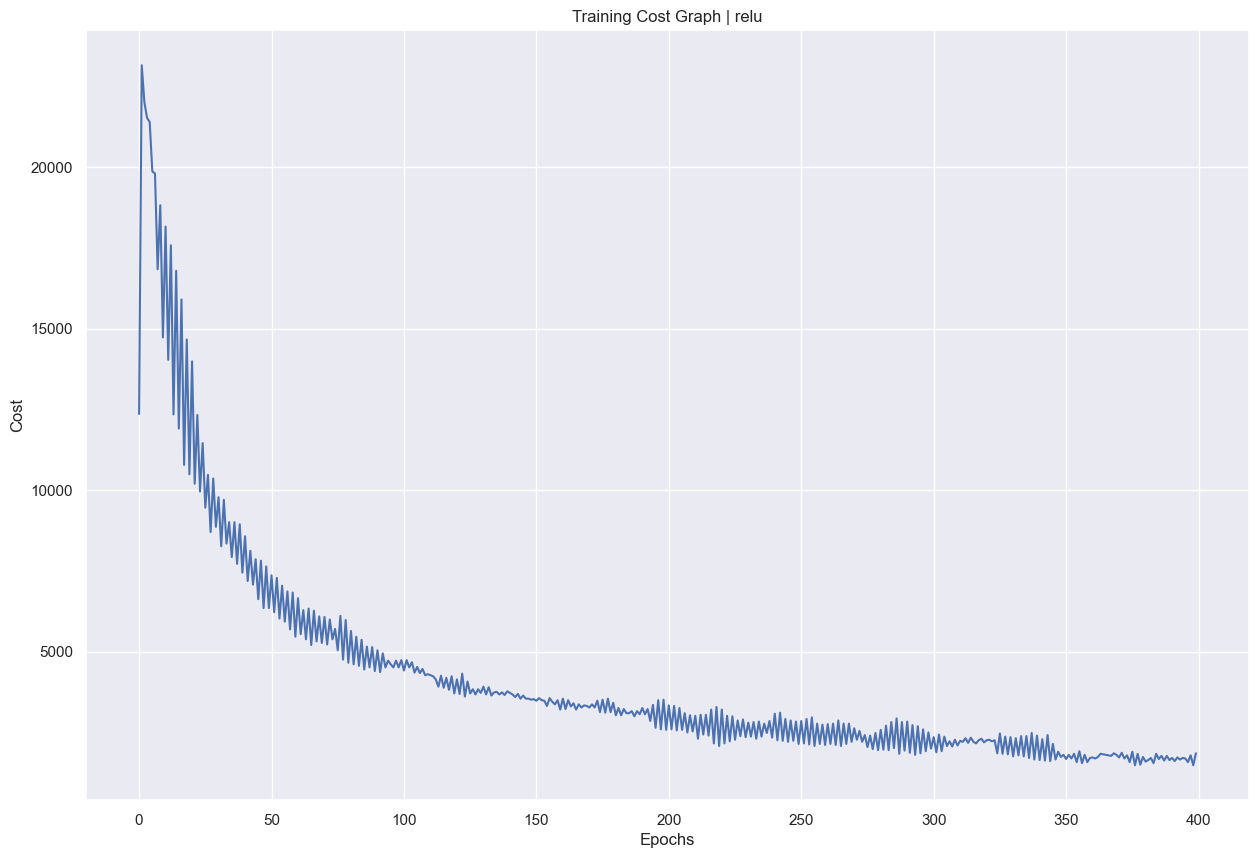

In [6]:
plt.figure(figsize=(15,10))
plt.plot(costList)
plt.title('Training Cost Graph | relu')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

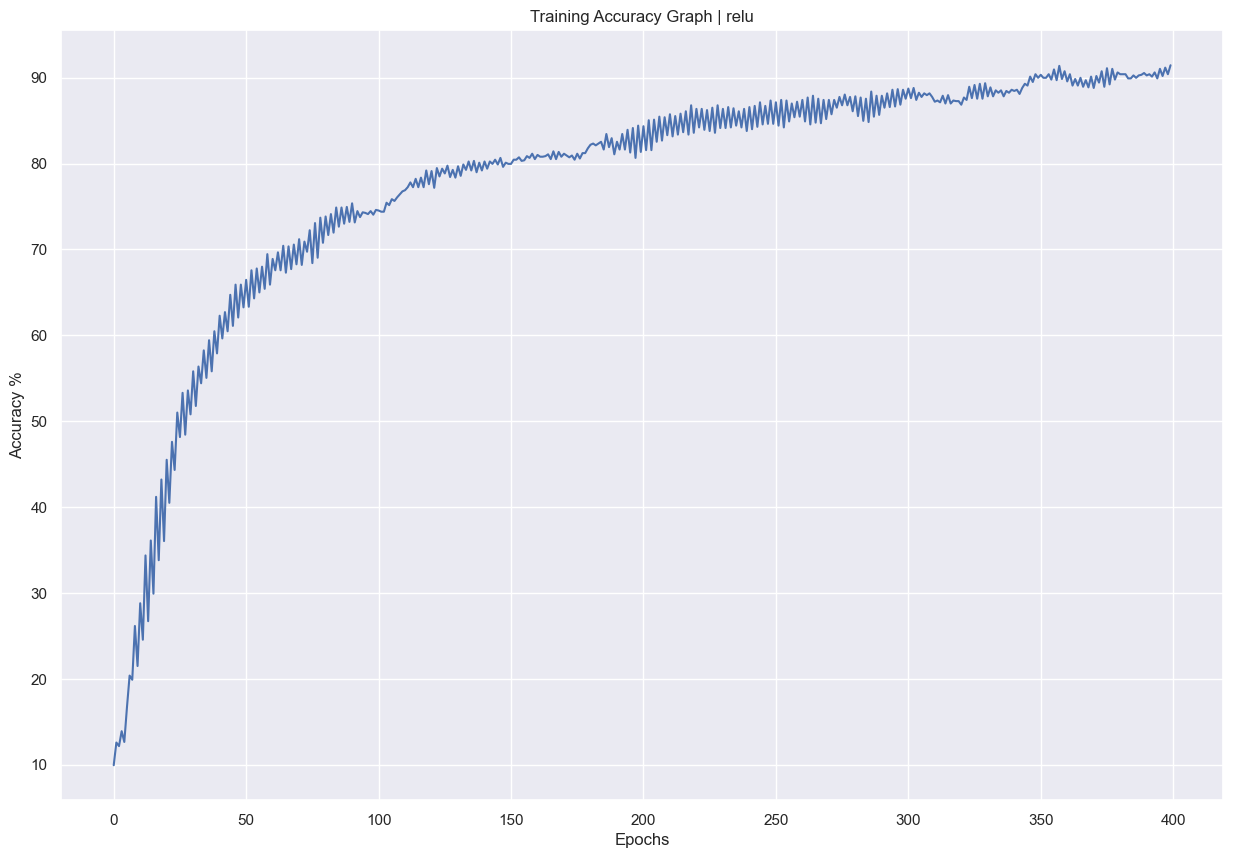

In [7]:
plt.figure(figsize=(15,10))
plt.plot(accList)
plt.title('Training Accuracy Graph | relu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.show()

<h3><h1><span style="color:red">Tanh</span>

In [11]:
obj1 = NeuralNetwork(x_train, y_train, "tanh",[x_train.shape[0], 700, 200, 10])
costList, accList = obj1.fit(0.01, 400)
testAcc = obj1.getAccuracy(x_test, y_test)
print('Test Accuracy is: ', np.round(testAcc, 3), '%')


Train Accuracy for epoch: 0 is: 12.317%
Train Accuracy for epoch: 40 is: 15.936%
Train Accuracy for epoch: 80 is: 23.104%
Train Accuracy for epoch: 120 is: 29.367%
Train Accuracy for epoch: 160 is: 35.56%
Train Accuracy for epoch: 200 is: 44.468%
Train Accuracy for epoch: 240 is: 52.679%
Train Accuracy for epoch: 280 is: 59.708%
Train Accuracy for epoch: 320 is: 65.901%
Train Accuracy for epoch: 360 is: 70.912%
Test Accuracy is:  60.278 %


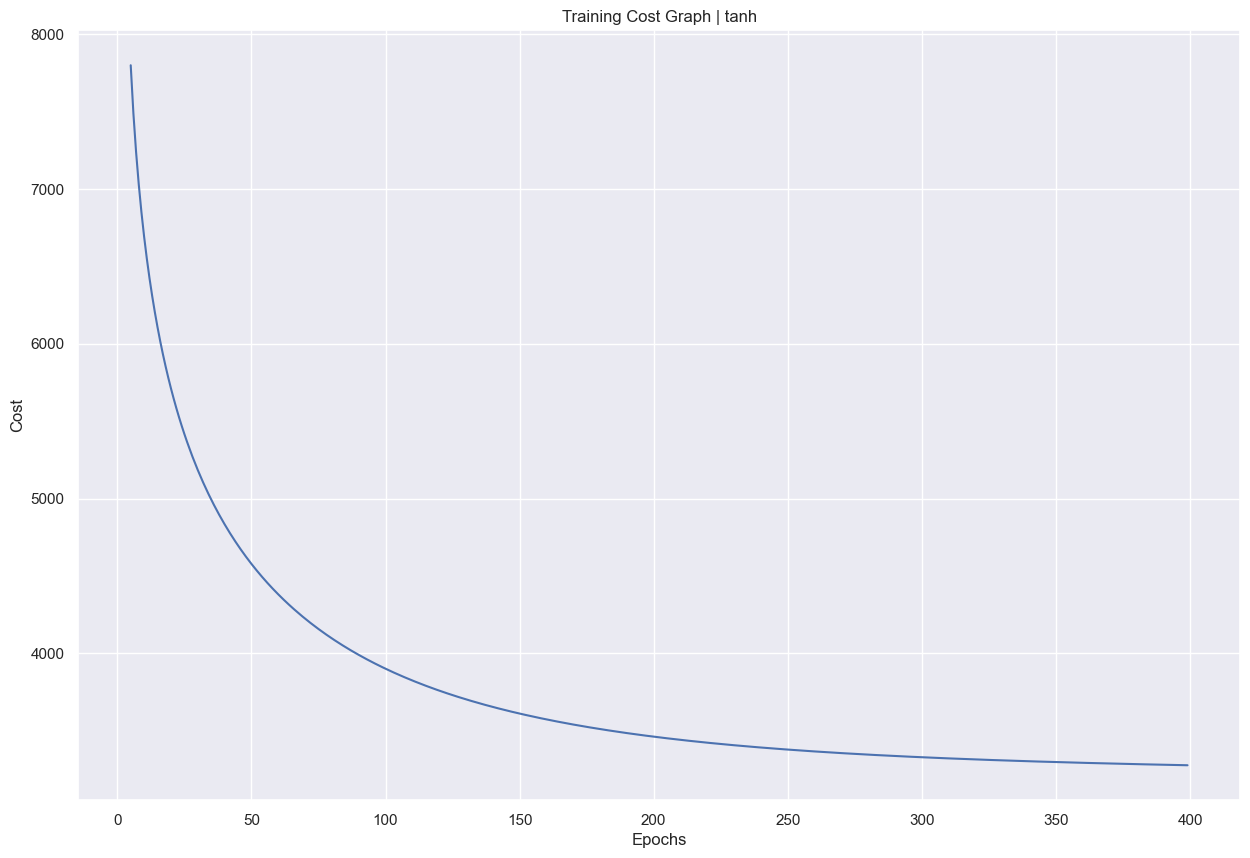

In [9]:
plt.figure(figsize=(15,10))
plt.plot(costList)
plt.title('Training Cost Graph | tanh')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

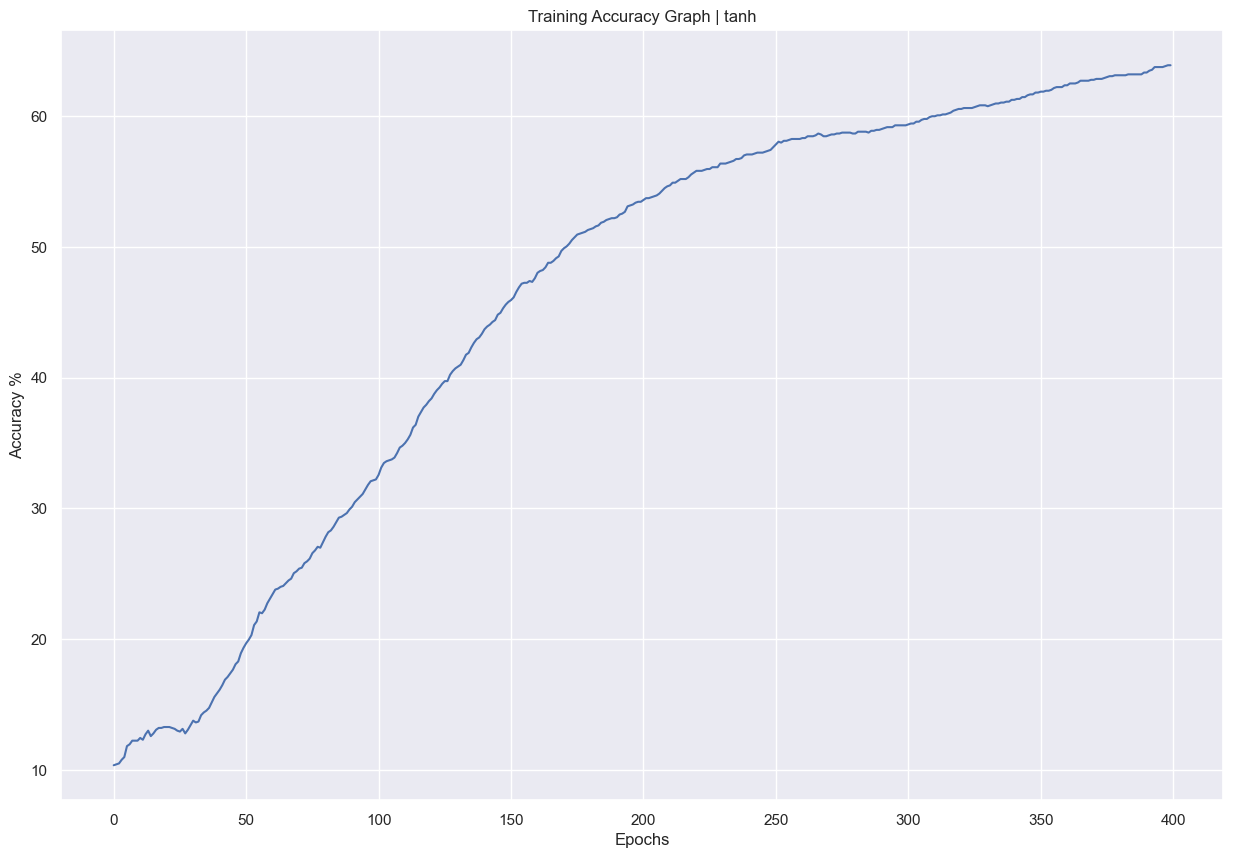

In [10]:
plt.figure(figsize=(15,10))
plt.plot(accList)
plt.title('Training Accuracy Graph | tanh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.show()